In [1]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from tqdm import tqdm
from datetime import datetime



c:\Users\conny\Anaconda3\envs\biofuzznet_dev\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import biofuzznet.biofuzznet as biofuzznet
import biofuzznet.biofuzzdataset as biofuzzdataset
import biofuzznet.Hill_function as Hill_function
import biofuzznet.utils as utils
import biofuzznet.biomixnet as biomixnet

xaxis = y_B_test
yaxis = copy.deepcopy(xaxis)
yaxis = yaxis.apply_(parameterized_Hill2)
plt.scatter(xaxis, yaxis)

In [3]:
torch.manual_seed(123)

s1 = torch.rand(1)
s2 = torch.rand(1)
s3 = torch.rand(1)

n1 = 5*torch.rand(1)
n2 = 5*torch.rand(1)
n3 = 5*torch.rand(1)

K1 = 1.5*torch.rand(1)
K2 = 1.5*torch.rand(1)
K3 = 1.5*torch.rand(1)

In [4]:


def parameterized_Hill1(x,n=n1, K=K1):
    return Hill(x, n, K)


def parameterized_Hill2(x, n=n2, K=K2):
    return Hill(x, n, K)

def parameterized_Hill3(x, n=n3, K=K3):
    return Hill(x, n, K)


def Hill(x, n, K):
    """Computes Hill function.

    Args:
        x: value to compute the function at
        n: Hill coefficient
        K: EC50 parameter such that Hill(K) = 0.5 if the scale parameter is 1
    """
    if x == 0:
        return 0
    else:
        output = (x ** n) / (
            K ** n + x ** n
        ) 
        return(output)

def  normalized_Hill(x, s, n, K):
    """Computes Hill function.

    Args:
    x: value to compute the function at
    s: scale parameter, between 0 and 1
    n: Hill coefficient
    K: EC50 parameter such that Hill(K) = 0.5 if the scale parameter is 1
    """
    if x == 0:
        return 0
    else:
        return (1+K**n) * s / (1 + (K / x) ** n)

# A simple cascade

In [5]:
# Input A is random values
X = torch.rand(1000)
y_A = copy.deepcopy(X)

# B is a Hill function of A
y_B = copy.deepcopy(X)
y_B = y_B.apply_(parameterized_Hill1) + torch.normal(0, 0.01, size=X.shape).apply_(
    np.abs
)

# C is a Hill function of B
y_C = copy.deepcopy(y_B)
y_C = y_C.apply_(parameterized_Hill2) + torch.normal(0, 0.01, size=y_B.shape).apply_(
    np.abs
)

X_test = torch.rand(100)
y_A_test = copy.deepcopy(X_test)

y_B_test = copy.deepcopy(X_test)
y_B_test = y_B_test.apply_(parameterized_Hill1) + torch.normal(
    0, 0.01, size=y_A_test.shape
).apply_(np.abs)

y_C_test = copy.deepcopy(y_B_test)
y_C_test = y_C_test.apply_(parameterized_Hill2) + torch.normal(
    0, 0.01, size=y_B_test.shape
).apply_(np.abs)

In [6]:
G = biofuzznet.BioFuzzNet(None, None)
G.add_fuzzy_node("A", "BIO")
G.add_fuzzy_node("B", "BIO" )
G.add_fuzzy_node("C", "BIO")


G.add_transfer_edge("A", "B")
G.add_transfer_edge("B", "C")

In [7]:
"D" in G.nodes()



False

In [8]:
learning_rate = 1e-2
epochs = 500
batch_size = 100

In [9]:
G.nodes["A"]


{'node_type': 'biological', 'output_state': None, 'ground_truth': None}

In [10]:
[(a,b,c) for a,b,c in G.edges(data=True) ]


[('A',
  'B',
  {'edge_type': 'transfer_function',
   'layer': HillTransferFunction(),
   'weight': 1}),
 ('B',
  'C',
  {'edge_type': 'transfer_function',
   'layer': HillTransferFunction(),
   'weight': 1})]

100%|██████████| 500/500 [02:10<00:00,  3.84it/s]


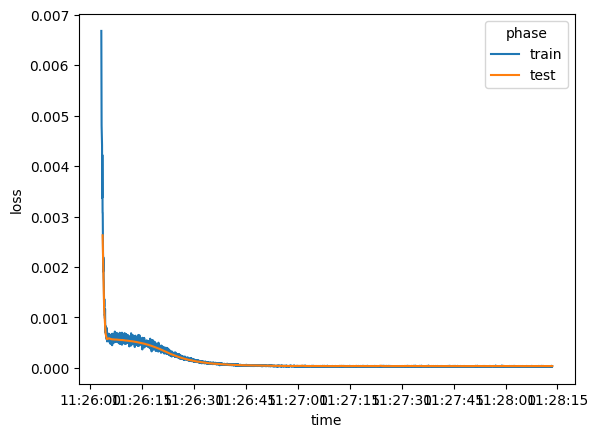

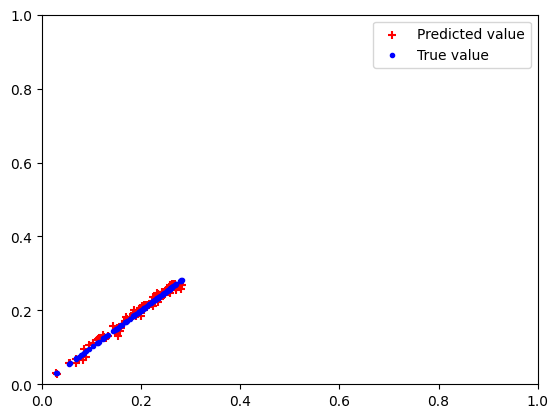

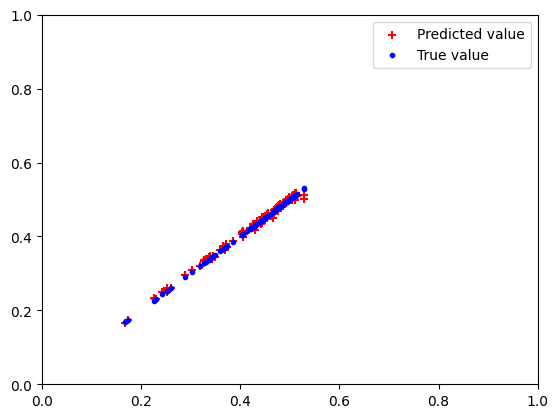

In [11]:
losses = G.conduct_optimisation(input = {"A": X}, ground_truth={"A":y_A, "B": y_B, "C":y_C},
test_input={"A": X_test}, test_ground_truth={"A": y_A_test, "B": y_B_test, "C": y_C_test}, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )
sns.lineplot(data=losses, x="time", y="loss", hue="phase")
plt.show()
plt.figure()
plt.scatter(y_C_test, G.nodes()["C"]["output_state"], color="red", label="Predicted value", marker="+")
plt.scatter(x=y_C_test, y=y_C_test, color="blue", label="True value", marker=".")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()
plt.figure()
plt.scatter(y_B_test, G.nodes()["B"]["output_state"], color="red", label="Predicted value", marker="+")
plt.scatter(x=y_B_test, y=y_B_test, color="blue", label="True value", marker=".")
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

# Introducing a NOT gate

In [12]:
G_not = biofuzznet.BioFuzzNet(None, None)
G_not.add_fuzzy_node("A", "BIO")
G_not.add_fuzzy_node("B", 'BIO')
G_not.add_fuzzy_node("NOT A", "NOT")


G_not.add_transfer_edge("A", "NOT A")
G_not.add_simple_edge("NOT A", "B")

In [13]:
NOT_A = torch.sub(torch.ones(1000), y_B)
NOT_A_test = torch.sub(torch.ones(100), y_B_test)
print([p for p in G_not.edges()["A", 'NOT A']["layer"].parameters()])

[Parameter containing:
tensor(0.8042, requires_grad=True), Parameter containing:
tensor(0.1462, requires_grad=True)]


100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


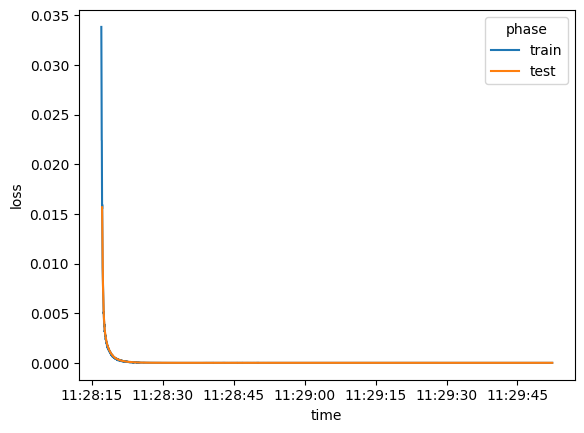

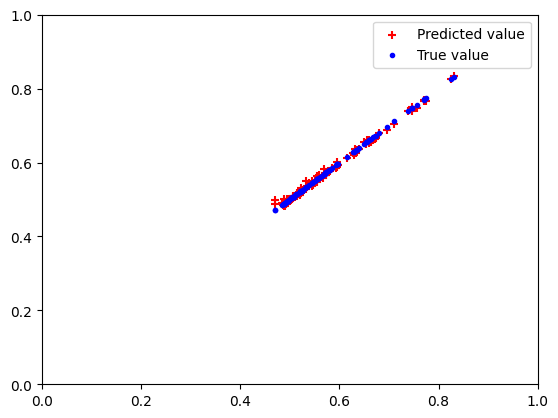

In [14]:
losses_not = G_not.conduct_optimisation(input = {"A": X}, ground_truth={"A":y_A, "B": NOT_A},
test_input={"A": X_test}, test_ground_truth={"A": y_A_test, "B": NOT_A_test}, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )
sns.lineplot(data=losses_not, x="time", y="loss", hue="phase")
plt.show()


plt.figure()
plt.scatter(NOT_A_test, G_not.nodes()["B"]["output_state"], color="red", label="Predicted value", marker="+")
plt.scatter(x=NOT_A_test, y=NOT_A_test, color="blue", label="True value", marker=".")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

In [15]:
losses_not

,time,loss,phase
0,2023-03-31 11:28:16.990477,0.033847,train
1,2023-03-31 11:28:17.008474,0.032264,train
2,2023-03-31 11:28:17.025473,0.029374,train
3,2023-03-31 11:28:17.043955,0.02731,train
4,2023-03-31 11:28:17.060969,0.023137,train
...,...,...,...
5495,2023-03-31 11:29:52.304562,0.00002,train
5496,2023-03-31 11:29:52.323621,0.000015,train
5497,2023-03-31 11:29:52.341613,0.000019,train
5498,2023-03-31 11:29:52.358606,0.000016,train


In [16]:
def get_parameters(G):
    layers = [G.edges()[e]["layer"] for e in G.transfer_edges]
    parameters = []
    for l in layers:
        parameters += [p for p in l.parameters()]
    return(parameters)
    

In [17]:
G_not_params = get_parameters(G_not)
for p in G_not_params:
    print(p.grad)

tensor(-0.0001)
tensor(2.3189e-05)


In [18]:
# A longer chain
G_not = biofuzznet.BioFuzzNet()
G_not.add_fuzzy_node("A", "BIO")
G_not.add_fuzzy_node("NOT A", "NOT")
G_not.add_fuzzy_node("B", 'BIO')
G_not.add_fuzzy_node("C", "BIO")
G_not.add_fuzzy_node("NOT C", "NOT")
G_not.add_fuzzy_node("D", "BIO")
G_not.add_fuzzy_node("E", "BIO")



G_not.add_transfer_edge("A", "NOT A")
G_not.add_simple_edge("NOT A", "B")
G_not.add_transfer_edge("B", "C")
G_not.add_transfer_edge("C", "NOT C")
G_not.add_simple_edge("NOT C", "D")
G_not.add_simple_edge("D", "E") # Normally should be a transfer edge, is a simple edge to check that single edge propagtaion works

In [19]:
# Input A is random values
X = torch.rand(1000)
y_A = copy.deepcopy(X)

# B is a NOT of Hill function of A
y_B = copy.deepcopy(X)
y_B = y_B.apply_(parameterized_Hill1) #+ torch.normal(0, 0.01, size=X.shape).apply_(
#    np.abs
#)
y_B = torch.sub(torch.ones(1000), y_B)

# C is a Hill function of B
y_C = copy.deepcopy(y_B)
y_C = y_C.apply_(parameterized_Hill2) #+ torch.normal(0, 0.01, size=y_B.shape).apply_(
#    np.abs
#)

# D is a NOT of Hill function of C
y_D = copy.deepcopy(y_C)
y_D = y_C.apply_(parameterized_Hill3) #+ torch.normal(0, 0.01, size=X.shape).apply_(
  #  np.abs
#)
y_D = torch.sub(torch.ones(1000), y_D)

# E is D
y_E = y_D

X_test = torch.rand(100)
y_A_test = copy.deepcopy(X_test)

# B is a NOT of Hill function of A
y_B_test = copy.deepcopy(X_test)
y_B_test = y_B_test.apply_(parameterized_Hill1) #+ torch.normal(0, 0.01, size=X_test.shape).apply_(
 #   np.abs
#)
y_B_test = torch.sub(torch.ones(100), y_B_test)

# C is a Hill function of B
y_C_test = copy.deepcopy(y_B_test)
y_C_test = y_C_test.apply_(parameterized_Hill2) #+ torch.normal(0, 0.01, size=y_B_test.shape).apply_(
  #  np.abs
#)

# D is a NOT of Hill function of C
y_D_test = copy.deepcopy(y_C_test)
y_D_test = y_C_test.apply_(parameterized_Hill3) #+ torch.normal(0, 0.01, size=X_test.shape).apply_(
 #   np.abs
#)
y_D_test = torch.sub(torch.ones(100), y_D_test)

# E is D
y_E_test = y_D_test

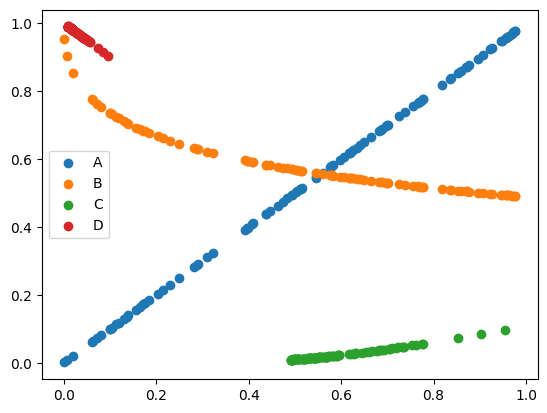

In [20]:
plt.scatter(X_test, y_A_test, label = "A")
plt.scatter(y_A_test, y_B_test, label = "B")
plt.scatter(y_B_test, y_C_test, label = "C")
plt.scatter(y_C_test, y_D_test, label = "D")
plt.legend()
plt.show()

100%|██████████| 500/500 [03:12<00:00,  2.60it/s]


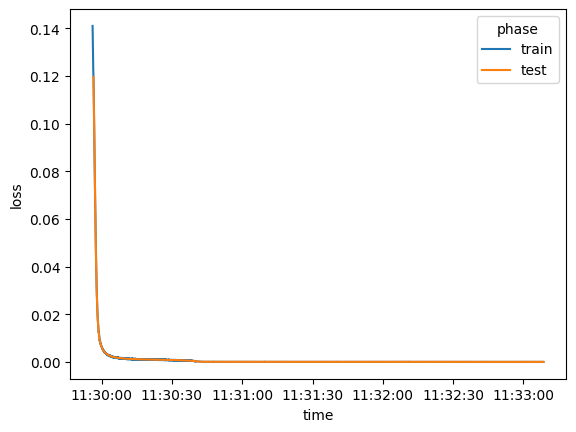

In [21]:
losses = G_not.conduct_optimisation(input = {"A":X}, ground_truth={"A":y_A, "B": y_B, "C": y_C, "D": y_D, "E": y_E},
test_input={"A":X_test}, test_ground_truth={"A": y_A_test, "B": y_B_test, "C": y_C_test, "D": y_D_test, "E": y_E_test}, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )
sns.lineplot(data=losses, x="time", y="loss", hue="phase")
plt.show()




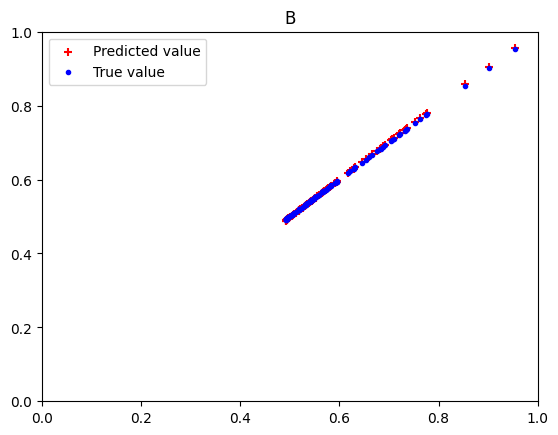

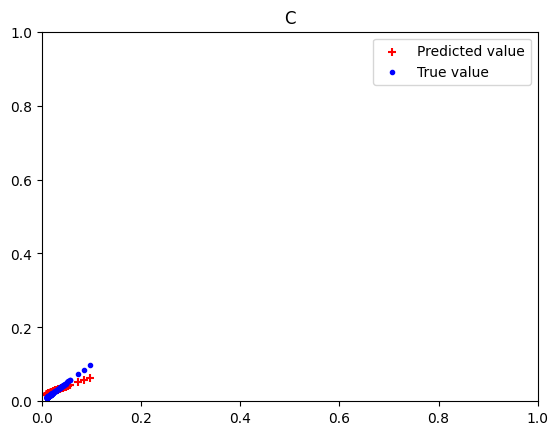

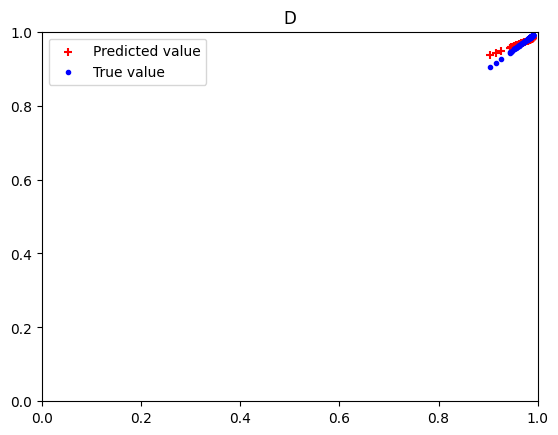

In [22]:
plt.figure()
plt.scatter(y_B_test, G_not.nodes()["B"]["output_state"], color="red", label="Predicted value", marker="+")
plt.scatter(x=y_B_test, y=y_B_test, color="blue", label="True value", marker=".")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("B")
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_C_test, G_not.nodes()["C"]["output_state"], color="red", label="Predicted value", marker="+")
plt.scatter(x=y_C_test, y=y_C_test, color="blue", label="True value", marker=".")
plt.title("C")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_D_test, G_not.nodes()["D"]["output_state"], color="red", label="Predicted value", marker="+")
plt.scatter(x=y_D_test, y=y_D_test, color="blue", label="True value", marker=".")
plt.title("D")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

# Test AND and OR gates

In [23]:
G_OR = biofuzznet.BioFuzzNet()
G_OR.add_fuzzy_node("A", "BIO")
G_OR.add_fuzzy_node("B", "BIO")
G_OR.add_fuzzy_node("C", "BIO")
G_OR.add_fuzzy_node("OR", "OR")

G_OR.add_transfer_edge("A", "OR")
G_OR.add_transfer_edge("B", "OR")
G_OR.add_simple_edge("OR", "C")

In [24]:
G_AND = biofuzznet.BioFuzzNet()
G_AND.add_fuzzy_node("A", "BIO")
G_AND.add_fuzzy_node("B", "BIO")
G_AND.add_fuzzy_node("C", "BIO")
G_AND.add_fuzzy_node("AND", "AND")

G_AND.add_transfer_edge("A", "AND")
G_AND.add_transfer_edge("B", "AND")
G_AND.add_simple_edge("AND", "C")

In [25]:
X_A = torch.rand(1000)
X_B = torch.rand(1000)

C_input_A = copy.deepcopy(X_A)
C_input_A = C_input_A.apply_(parameterized_Hill1)

C_input_B = copy.deepcopy(X_B)
C_input_B = C_input_B.apply_(parameterized_Hill2)

y_C_AND = torch.multiply(C_input_A, C_input_B) 

y_C_OR = torch.sub(torch.add(C_input_A, C_input_B), y_C_AND)



X_A_test = torch.rand(100)
X_B_test = torch.rand(100)

C_input_A_test = copy.deepcopy(X_A_test)
C_input_A_test = C_input_A_test.apply_(parameterized_Hill1)

C_input_B_test = copy.deepcopy(X_B_test)
C_input_B_test = C_input_B_test.apply_(parameterized_Hill2)

y_C_AND_test = torch.multiply(C_input_A_test, C_input_B_test  ) 

y_C_OR_test = torch.sub(torch.add(C_input_A_test, C_input_B_test), y_C_AND_test)

100%|██████████| 500/500 [02:32<00:00,  3.28it/s]


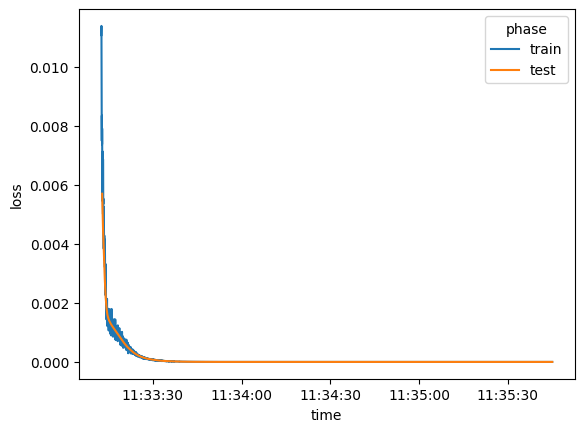

In [26]:
losses_OR = G_OR.conduct_optimisation(input = {"A":X_A, "B": X_B}, ground_truth={"A":X_A, "B": X_B, "C": y_C_OR},
test_input={"A":X_A_test,"B": X_B_test}, test_ground_truth={"A": X_A_test, "B": X_B_test, "C": y_C_OR_test}, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )
sns.lineplot(data=losses_OR, x="time", y="loss", hue="phase")
plt.show()


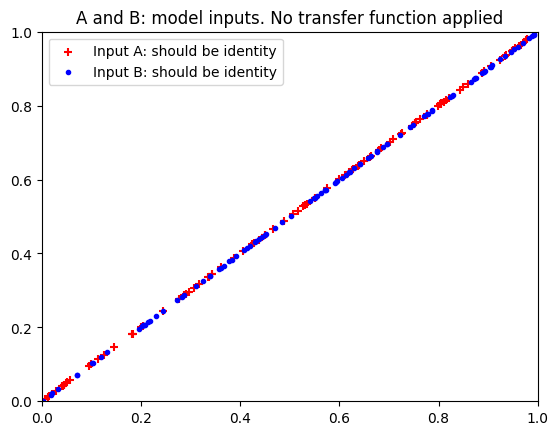

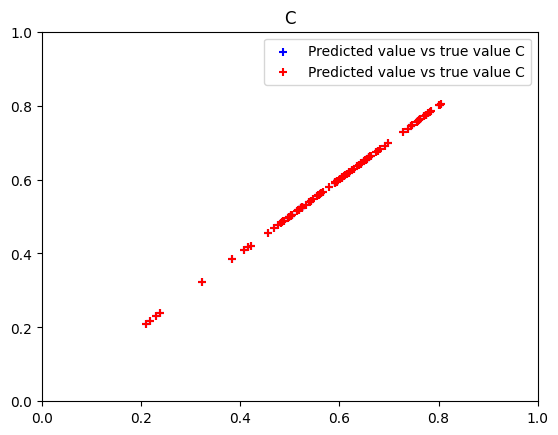

In [27]:
plt.figure()
plt.scatter(X_A_test, G_OR.nodes()["A"]["output_state"], color="red", label="Input A: should be identity", marker="+")
plt.scatter(X_B_test, G_OR.nodes()["B"]["output_state"], color="blue", label="Input B: should be identity", marker=".")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("A and B: model inputs. No transfer function applied")
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_C_OR_test, G_OR.nodes()["C"]["output_state"], color="blue", label="Predicted value vs true value C", marker="+")
plt.scatter(y_C_OR_test, y_C_OR_test, color="red", label="Predicted value vs true value C", marker="+")
plt.title("C")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

100%|██████████| 500/500 [02:17<00:00,  3.63it/s]


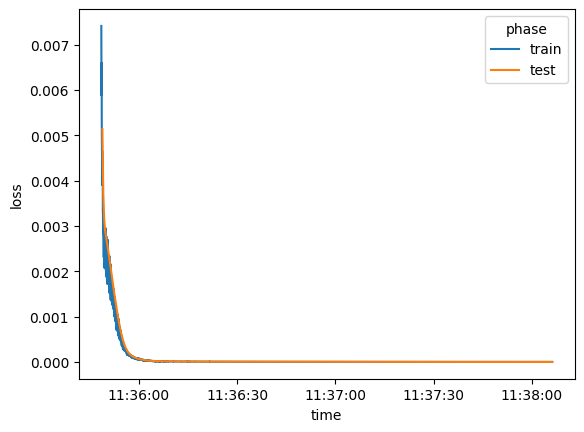

In [28]:
losses_AND = G_AND.conduct_optimisation(input = {"A":X_A, "B": X_B}, ground_truth={"A":X_A, "B": X_B, "C": y_C_AND},
test_input={"A":X_A_test,"B": X_B_test}, test_ground_truth={"A": X_A_test, "B": X_B_test, "C": y_C_AND_test}, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )
sns.lineplot(data=losses_AND, x="time", y="loss", hue="phase")
plt.show()

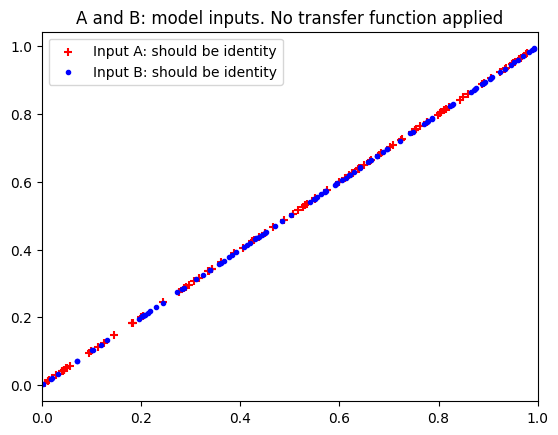

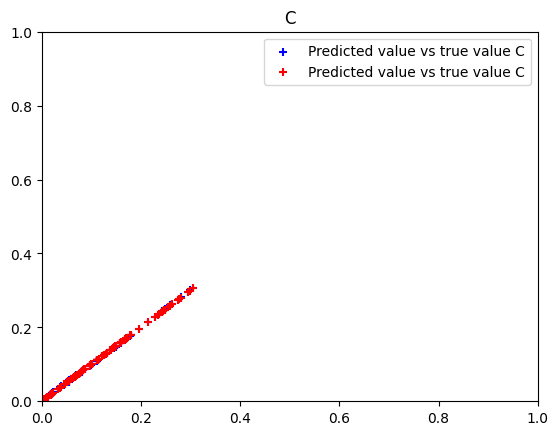

In [29]:
plt.figure()
plt.scatter(X_A_test, G_AND.nodes()["A"]["output_state"], color="red", label="Input A: should be identity", marker="+")
plt.scatter(X_B_test, G_AND.nodes()["B"]["output_state"], color="blue", label="Input B: should be identity", marker=".")
plt.xlim(0,1)
plt.title("A and B: model inputs. No transfer function applied")
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_C_AND_test, G_AND.nodes()["C"]["output_state"], color="blue", label="Predicted value vs true value C", marker="+")
plt.scatter(y_C_AND_test,y_C_AND_test, color="red", label="Predicted value vs true value C", marker="+")

plt.title("C")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

# Multiple input nodes

In [30]:
learning_rate = 1e-3
epochs = 500
batch_size = 100

In [31]:
G1 = biofuzznet.BioFuzzNet()
G1.add_node("A", node_type = "biological", output_state = None, ground_truth = None)
G1.add_node("B", node_type = "biological", output_state = None, ground_truth = None)
G1.add_node("C", node_type = "biological", output_state = None, ground_truth = None)
G1.add_node("D", node_type = "biological", output_state = None, ground_truth = None)
G1.add_node("E", node_type = "biological", output_state = None, ground_truth = None)
G1.add_fuzzy_node("NOT_E", "NOT") 
G1.add_node("F", node_type = "biological", output_state = None, ground_truth = None)
G1.add_fuzzy_node("NOT_A", "NOT")

G1.add_edge("A", "NOT_A", edge_type = "transfer_function", layer = Hill_function.HillTransferFunction())
G1.add_simple_edge("NOT_A", "B")
G1.add_edge("B", "C", edge_type = "transfer_function", layer = Hill_function.HillTransferFunction())
G1.add_edge("B", "D", edge_type = "transfer_function", layer = Hill_function.HillTransferFunction())
G1.add_edge("E", "NOT_E", edge_type = "transfer_function", layer = Hill_function.HillTransferFunction())
G1.add_edge("NOT_E", "F", edge_type = "simple")

In [32]:
X_A = torch.rand(1000)
y_A = X_A

X_E = torch.rand(1000)
y_E = X_E

# F is a NOT of a Hill function of E
y_F = copy.deepcopy(X_E)
y_F = y_F.apply_(parameterized_Hill3)
y_F = torch.sub(torch.ones(1000), y_F)

# B is a NOT of a Hill function of A
y_B = copy.deepcopy(X_A)
y_B = y_B.apply_(parameterized_Hill2)
y_B = torch.sub(torch.ones(1000), y_B)

# C is a Hill function of B
y_C = copy.deepcopy(y_B)
y_C = y_C.apply_(parameterized_Hill1)

# D is a Hill function of B
y_D = copy.deepcopy(y_B)
y_D = y_D.apply_(parameterized_Hill2)

######################## TEST ###########
X_A_test = torch.rand(100)
y_A_test = X_A_test

X_E_test = torch.rand(100)
y_E_test = X_E_test

# F is a NOT of a Hill function of E
y_F_test = copy.deepcopy(X_E_test)
y_F_test = y_F_test.apply_(parameterized_Hill3)
y_F_test = torch.sub(torch.ones(100), y_F_test)

# B is a NOT of a Hill function of A
y_B_test = copy.deepcopy(X_A_test)
y_B_test = y_B_test.apply_(parameterized_Hill2)
y_B_test = torch.sub(torch.ones(100), y_B_test)

# C is a Hill function of B
y_C_test = copy.deepcopy(y_B_test)
y_C_test = y_C_test.apply_(parameterized_Hill1)

# D is a Hill function of B
y_D_test = copy.deepcopy(y_B_test)
y_D_test = y_D_test.apply_(parameterized_Hill2)

100%|██████████| 500/500 [03:36<00:00,  2.31it/s]


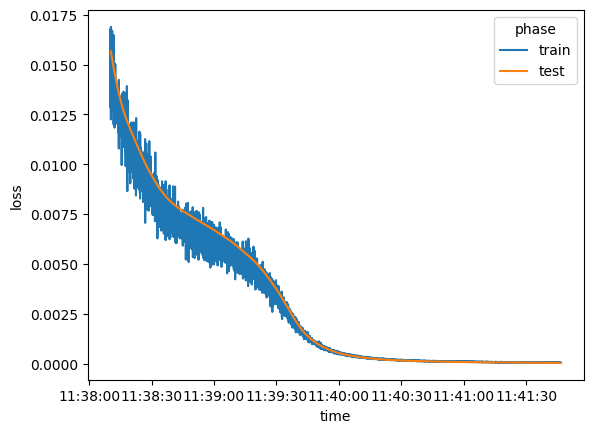

In [33]:
losses = G1.conduct_optimisation(input = {"A":X_A, "E":X_E}, ground_truth={"A":y_A, "B": y_B, "C":y_C, "D": y_D, "E": y_E, "F": y_F},
test_input={"A":X_A_test, "E":X_E_test}, test_ground_truth={"A": X_A_test, "B": y_B_test, "C": y_C_test, "D": y_D_test, "E": X_E_test, "F": y_F_test}, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )

sns.lineplot(data=losses, x="time", y="loss", hue="phase")
plt.show()


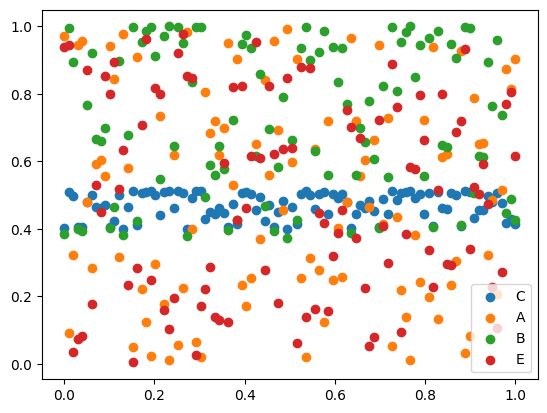

In [34]:
x = np.linspace(0,1,100)
plt.scatter(x, y_C_test, label = "C")
plt.scatter(x, y_A_test, label = "A")
plt.scatter(x, y_B_test, label = "B")
plt.scatter(x, y_E_test, label = "E")
plt.legend()
plt.show()

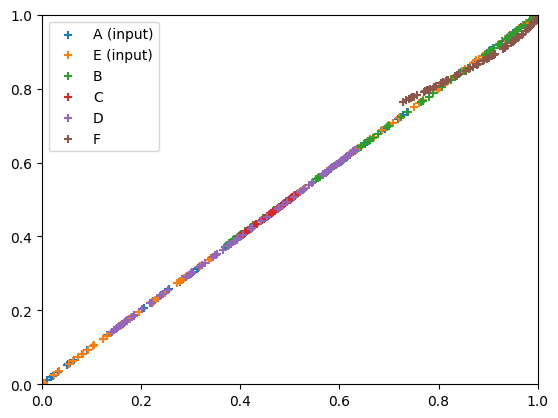

In [35]:

plt.figure()
plt.scatter(y_A_test, G1.nodes()["A"]["output_state"], label="A (input)", marker="+")
plt.scatter(y_E_test, G1.nodes()["E"]["output_state"], label="E (input)", marker="+")
plt.scatter(y_B_test, G1.nodes()["B"]["output_state"],  label="B", marker="+")

plt.scatter(y_C_test, G1.nodes()["C"]["output_state"],  label="C", marker="+")
plt.scatter(y_D_test, G1.nodes()["D"]["output_state"],  label="D", marker="+")
plt.scatter(y_F_test, G1.nodes()["F"]["output_state"], label="F", marker="+")

plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()

# A few simple loops 

Strictly speaking, those loops do not have leaf nodes. They however do have a root node.

In [36]:
# A first example

def create_my_loop() -> biofuzznet.BioFuzzNet:
    my_loop = biofuzznet.BioFuzzNet()
    my_loop.add_fuzzy_node("A", "BIO")
    my_loop.add_fuzzy_node("B", "BIO")
    my_loop.add_fuzzy_node("C", "BIO")
    my_loop.add_fuzzy_node("D", "BIO")
    my_loop.add_fuzzy_node("NOT_D", "NOT")
    my_loop.add_fuzzy_node("OR", "OR")
    my_loop.add_fuzzy_node("AND", "AND")

    my_loop.add_transfer_edge("A", "AND")
    my_loop.add_transfer_edge("B", "C")
    my_loop.add_transfer_edge("C", "D")
    my_loop.add_transfer_edge("C", "OR")
    my_loop.add_transfer_edge("D", "NOT_D")

    my_loop.add_simple_edge("NOT_D", "AND")
    my_loop.add_simple_edge("AND", "OR")
    my_loop.add_simple_edge("OR", "B")
    return(my_loop)

my_loop = create_my_loop()


# Test utils.has_cycle function
utils.has_cycle(my_loop)

(True, [['B', 'C', 'D', 'NOT_D', 'AND', 'OR'], ['B', 'C', 'OR']])

In [37]:

def create_second_loop()-> biofuzznet.BioFuzzNet:
    second_loop = biofuzznet.BioFuzzNet()

    second_loop.add_fuzzy_node("A", "BIO")
    second_loop.add_fuzzy_node("B", "BIO")
    second_loop.add_fuzzy_node("C", "BIO")
    second_loop.add_fuzzy_node("D", "BIO")
    second_loop.add_fuzzy_node("OR1", "OR")
    second_loop.add_fuzzy_node("OR2", "OR")

    second_loop.add_transfer_edge("A", "OR1")
    second_loop.add_transfer_edge("B", "C")
    second_loop.add_transfer_edge("B", "D")
    second_loop.add_transfer_edge("D", "OR1")
    second_loop.add_simple_edge("OR1", "OR2")
    second_loop.add_transfer_edge("C", "OR2")
    second_loop.add_simple_edge("OR2", "B")
    return(second_loop)

second_loop = create_second_loop()


# Test utils.has_cycle function
utils.has_cycle(second_loop)

(True, [['B', 'C', 'OR2'], ['B', 'D', 'OR1', 'OR2']])

## Simulate and optimise the first loop

In [38]:
# See if I can simulate

# Use the predefined random states for generating the results
my_loop.initialise_random_truth_and_output(1000)
inputs_my_loop = {n: my_loop.nodes()[n]["output_state"] for n in my_loop.root_nodes}

# Set ground truth for root nodes
for n in my_loop.root_nodes:
    my_loop.nodes()[n]["output_state"] = my_loop.nodes()[n]["ground_truth"]

# Simulate
my_loop.sequential_update(my_loop.root_nodes)

# The random initialisation of the Hill functions will be our ground truth
# Save the parameters of the Hill functions we used
parameters_dict = {e : [p for p in my_loop.edges()[e]["layer"].parameters()] for e in my_loop.transfer_edges}

# The result of the simulation will be our ground truth
ground_truth_my_loop = my_loop.output_states

In [39]:
# Then re-define the network to generate new parameters at the gates 
my_loop = create_my_loop()

# Define a train and test set
train_input_my_loop = {key: val[0:900] for key, val in inputs_my_loop.items()}
test_input_my_loop = {key: val[900:1000] for key, val in inputs_my_loop.items()}

train_ground_truth_my_loop = {key: val[0:900] for key, val in ground_truth_my_loop.items()}
test_ground_truth_my_loop= {key: val[900:1000] for key, val in ground_truth_my_loop.items()}

In [42]:
epochs = 500
learning_rate = 1e-3
batch_size = 100


100%|██████████| 5/5 [01:42<00:00, 20.54s/it]


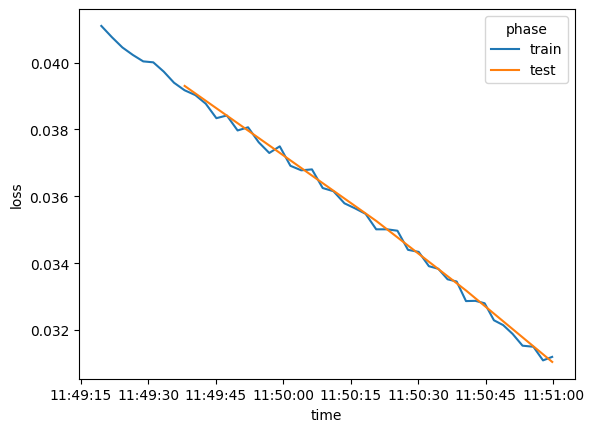

In [43]:
# Optimise
losses_my_loop = my_loop.conduct_optimisation(input = train_input_my_loop, ground_truth=train_ground_truth_my_loop,
test_input=test_input_my_loop, test_ground_truth=test_ground_truth_my_loop, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )

sns.lineplot(data=losses_my_loop, x="time", y="loss", hue="phase")
plt.show()

## Same process with the second loop

In [ ]:
# See if I can simulate
# Use the predefined random states for generating the results

second_loop.initialise_random_truth_and_output(1000)
inputs_second_loop = {n: second_loop.nodes()[n]["output_state"] for n in second_loop.root_nodes}

# Set ground truth for root nodes
for n in second_loop.root_nodes:
    second_loop.nodes()[n]["output_state"] = second_loop.nodes()[n]["ground_truth"]

# Simulate
second_loop.sequential_update(second_loop.root_nodes)

# The random initialisation of the Hill functions will be our ground truth
# Save the parameters of the Hill functions we used
parameters_dict_second_loop = {e : [p for p in second_loop.edges()[e]["layer"].parameters()] for e in second_loop.transfer_edges}

# The result of the simulation will be our ground truth
ground_truth_second_loop = {n: second_loop.nodes()[n]["output_state"] for n in second_loop.biological_nodes}

In [ ]:
# Re-define model to re-initialise the parameters at the gates
second_loop = create_second_loop()


# Define a train and test set
train_input_second_loop = {key: val[0:900] for key, val in inputs_second_loop.items()}
test_input_second_loop = {key: val[900:1000] for key, val in inputs_second_loop.items()}

train_ground_truth_second_loop = {key: val[0:900] for key, val in ground_truth_second_loop.items()}
test_ground_truth_second_loop = {key: val[900:1000] for key, val in ground_truth_second_loop.items()}

In [ ]:
losses_second_loop = second_loop.conduct_optimisation(input = train_input_second_loop, ground_truth=train_ground_truth_second_loop,
test_input=test_input_second_loop, test_ground_truth=test_ground_truth_second_loop, epochs=500, learning_rate=learning_rate, batch_size=batch_size  )

sns.lineplot(data=losses_second_loop, x="time", y="loss", hue="phase")
plt.show()

In [ ]:
plt.figure()
plt.scatter(my_loop.nodes()["A"]["ground_truth"].detach(), my_loop.nodes()["A"]["output_state"].detach(), label="A (input)", marker="+")
plt.scatter(my_loop.nodes()["B"]["ground_truth"].detach(), my_loop.nodes()["B"]["output_state"].detach(),  label="B", marker="+")

plt.scatter(my_loop.nodes()["C"]["ground_truth"].detach(), my_loop.nodes()["C"]["output_state"].detach(),  label="C", marker="+")
plt.scatter(my_loop.nodes()["D"]["ground_truth"].detach(), my_loop.nodes()["D"]["output_state"].detach(),  label="D", marker="+")

plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()

In [ ]:
plt.figure()
plt.scatter(second_loop.nodes()["A"]["ground_truth"].detach(), second_loop.nodes()["A"]["output_state"].detach(), label="A (input)", marker="+")
plt.scatter(second_loop.nodes()["B"]["ground_truth"].detach(), second_loop.nodes()["B"]["output_state"].detach(),  label="B", marker="+")

plt.scatter(second_loop.nodes()["C"]["ground_truth"].detach(), second_loop.nodes()["C"]["output_state"].detach(),  label="C", marker="+")
plt.scatter(second_loop.nodes()["D"]["ground_truth"].detach(), second_loop.nodes()["D"]["output_state"].detach(),  label="D", marker="+")

plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()

# Setting aside optimisation, let us just see how our sequential update algorithm works on loops

ie let us check that it seems to converge


In [ ]:
second_loop = create_second_loop()

In [ ]:
# See if I can simulate
# Use the predefined random states for generating the results

second_loop.initialise_random_truth_and_output(10)
inputs_second_loop = {n: second_loop.nodes()[n]["output_state"] for n in second_loop.root_nodes}

# Set ground truth for root nodes
for n in second_loop.root_nodes:
    second_loop.nodes()[n]["output_state"] = second_loop.nodes()[n]["ground_truth"]

# Simulate
# Uncomment lines for checking convergence in Biofuzznet.biofuzznet
states = second_loop.sequential_update(second_loop.root_nodes, convergence_check = True)

In [ ]:
# Plot the different nodes

def plot_node_results(graph, states, node):
    for i in range(graph.output_states[node].size()[0]): # Ie for each cell
        sns.lineplot(x= [t for t in states.keys()], y = [states[t][node][i].detach().item() for t in states.keys()])

for node in second_loop.biological_nodes:
    plt.figure()
    plot_node_results(second_loop, states, node)
    plt.title(node)

In [ ]:
plt.close("all")